In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import nltk
from nltk import tokenize
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from string import punctuation
from razdel import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from natasha import MorphVocab, Doc, Segmenter, NewsEmbedding, NewsMorphTagger

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
df = pd.read_csv('e-catalog_phone_reviews.csv', index_col=0)

In [3]:
df

,review,type
0,Советую модель на 128 GB. Именно Pro в ней ест...,/img/svg/review-smile-4.svg
1,"Телефон - огонь) Хорошая модель, мне понравило...",/img/svg/review-smile-4.svg
2,"Аппарат очень хороший,конечно рекомендую к пре...",/img/svg/review-smile-4.svg
3,"Уверен, что телефон своих денег стои, а баланс...",/img/svg/review-smile-3.svg
4,"Всем рекомендую) Итак, искал я телефон для пок...",/img/svg/review-smile-4.svg
...,...,...
3685,"Не берите,за эти деньги можно найти и получше....",/img/svg/review-smile-1.svg
3686,модель с серьезными недостатками Тот телефон у...,/img/svg/review-smile-1.svg
3687,модель с серьезными недостатками Игры вылетают...,/img/svg/review-smile-1.svg
3688,"хорошая модель, понравилось У меня есть этот т...",/img/svg/review-smile-3.svg


## Преобразуем к двум типам

####  (/img/svg/review-smile-4.svg) --> 1

####  (/img/svg/review-smile-3.svg) --> 1

####  (/img/svg/review-smile-2.svg) --> 0

####  (/img/svg/review-smile-1.svg) --> 0

In [4]:
def convert_to_2_types(val):
    if val == '/img/svg/review-smile-4.svg':
        return 1
    elif val == '/img/svg/review-smile-3.svg':
        return 1
    elif val == '/img/svg/review-smile-2.svg':
        return 0
    elif val == '/img/svg/review-smile-1.svg':
        return 0

In [5]:
df['type'] = df['type'].apply(lambda x: convert_to_2_types(x))

In [6]:
df['type'].value_counts(normalize=True)

1    0.803145
0    0.196855
Name: type, dtype: float64

### Наблюдается большой дисбаланс классов. Считаю, что можно пожертвовать частью наблюдений и произвести undersampling.

In [7]:
fewer_class_count = len(df.loc[df['type'] == 0])

In [8]:
df = df.loc[df['type'] == 1].sample(fewer_class_count).append(df.loc[df['type'] == 0])

In [9]:
df['type'].value_counts(normalize=True)

0    0.5
1    0.5
Name: type, dtype: float64

## Text Preprocessing

### Приведем к нижнему регистру

In [10]:
df['review'] = df['review'].str.lower()

### Уберем лишние символы

In [11]:
pat = r'[^0-9a-zA-zа-яёА-ЯЁ\-]'

def clean_str(val):
    
    val = re.sub(pat, ' ', val)
    
    val = val.replace(' -', ' ')
    val = val.replace('- ', ' ')
    val = val.replace(' - ', ' ')
    val = val.replace('  ', ' ')
    val = val.strip()
    
    return val

df['review'] = df['review'].apply(lambda x: clean_str(x))

### Токенизируем

In [12]:
df['review'] = df['review'].apply(lambda x: [y.text for y in tokenize(x)])

### Уберем стоп-слова и одиночные буквы

In [13]:
stop_words = stopwords.words('russian') + stopwords.words('english')

In [14]:
df['review'] = df['review'].apply(lambda x: [y for y in x if y not in stop_words and len(y) > 1])

### Лемматизация

In [15]:
morph_vocab = MorphVocab()
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
    
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text_list):
    doc = Doc(' '.join(text_list))
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    # лемматизация русских слов
    for token in doc.tokens:    
        token.lemmatize(morph_vocab)
    
    result = [x.lemma for x in doc.tokens]
    
    # лемматизация английских слов
    result = [lemmatizer.lemmatize(x) for x in result]

    return result

In [16]:
df['review'] = df['review'].apply(lambda x: lemmatize_text(x))

In [17]:
df['review'] = df['review'].apply(lambda x: ' '.join(x))

In [18]:
df.head()

,review,type
2093,хороший модель понравиться нормальный тел отли...,1
3001,отличный модель очень понравиться рассекатель ...,1
96,отличный смартфон хороший бюджетный смартфон 1...,1
2610,достойный смартфон рекомендовать отличный теле...,1
3072,хороший модель понравиться процессор задний ка...,1


## CountVectorizer

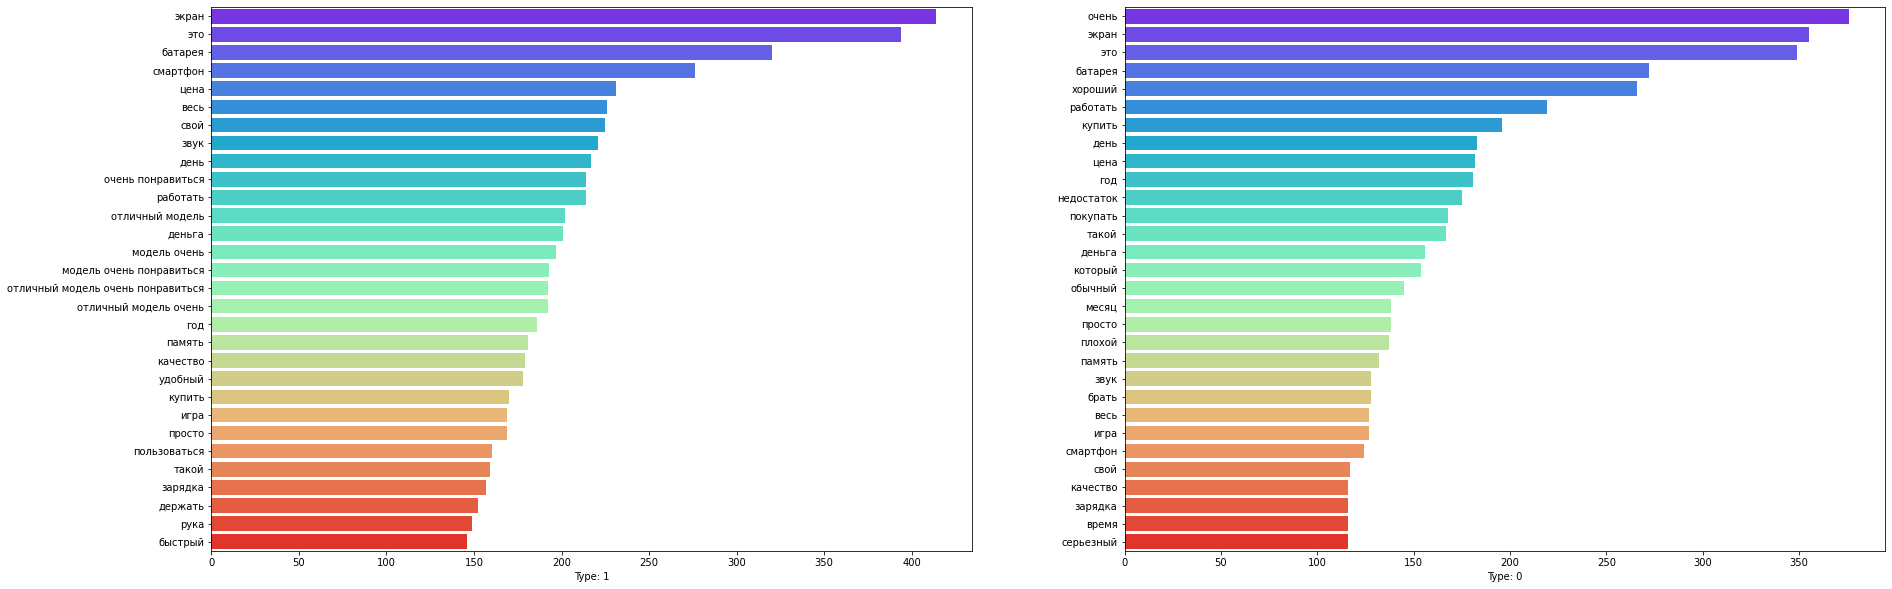

In [86]:
fig,ax = plt.subplots(1, 2, figsize=(30, 10))

i = 0

for review_type in df['type'].unique():
    vectorizer = CountVectorizer(max_df=0.4, min_df=0.01, ngram_range=(1, 4), max_features=1000)
    words = df.loc[df['type'] == review_type]['review'].to_list()
    vector = vectorizer.fit_transform(words)
    series = pd.DataFrame(data=vector.toarray(), 
                          columns=vectorizer.get_feature_names()).sum().sort_values(ascending=False)
    
    ax[i].set_xlabel(f'Type: {review_type}')
    sns.barplot(x=series.head(30), y=series.head(30).index, palette='rainbow', ax=ax[i])
    
    i += 1

## Splitting

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['type'], random_state=42, test_size=0.25)

## TF IDF

In [88]:
tf_idf_vec = TfidfVectorizer(max_df=0.6, min_df=0.006, ngram_range=(1, 4), max_features=1000, norm=False)

X_train_tf = tf_idf_vec.fit_transform(X_train)
X_train_tf = pd.DataFrame(data=X_train_tf.toarray(), columns=tf_idf_vec.get_feature_names())

X_test_tf = tf_idf_vec.transform(X_test)
X_test_tf = pd.DataFrame(data=X_test_tf.toarray(), columns=tf_idf_vec.get_feature_names())

In [89]:
print(len(X_train_tf), len(X_test_tf))

1089 363


## Plot Feature Importance

In [90]:
def plot_feature_impotance(feature_impotance_array):
    fig, ax = plt.subplots(1, 2, figsize=(25, 8))

    labels = ['Positive', 'Negative']

    featureImportance_positive = pd.DataFrame({"feature": X_train_tf.columns[feature_impotance_array != 0], 
                                      "importance": feature_impotance_array[feature_impotance_array!=0]}).sort_values(by='importance', ascending=False).head(25)

    featureImportance_negative = pd.DataFrame({"feature": X_train_tf.columns[feature_impotance_array != 0], 
                                      "importance": feature_impotance_array[feature_impotance_array!=0]}).sort_values(by='importance', ascending=True).head(25)

    sns.barplot(x='importance', y='feature', data=featureImportance_positive, ax=ax[1])
    sns.barplot(x='importance', y='feature', data=featureImportance_negative, ax=ax[0])

    ax[0].set_xlabel('Negative Sentiment')
    ax[0].set_ylabel(None)
    ax[1].set_xlabel('Positive Sentiment')
    ax[1].set_ylabel(None)

## Naive Bayes

In [91]:
mnnb = MultinomialNB()
mnnb.fit(X_train_tf, y_train)
preds = mnnb.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))
print(f'ROC AUC score: {roc_auc_score(y_test, preds)}')

              precision    recall  f1-score   support

           0     0.8611    0.8333    0.8470       186
           1     0.8306    0.8588    0.8444       177

    accuracy                         0.8457       363
   macro avg     0.8459    0.8460    0.8457       363
weighted avg     0.8462    0.8457    0.8458       363

ROC AUC score: 0.846045197740113


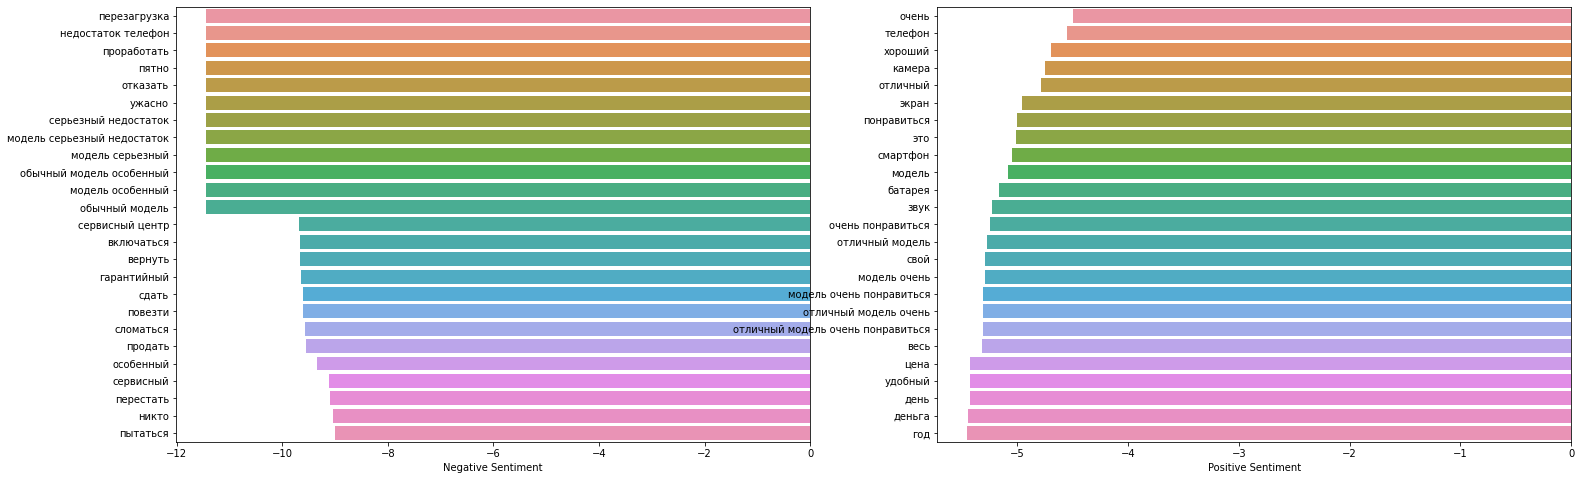

In [92]:
plot_feature_impotance(mnnb.coef_[0])

## Random Forest

In [93]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tf, y_train)
preds = rf.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))
print(f'ROC AUC score: {roc_auc_score(y_test, preds)}')

              precision    recall  f1-score   support

           0     0.8254    0.8387    0.8320       186
           1     0.8276    0.8136    0.8205       177

    accuracy                         0.8264       363
   macro avg     0.8265    0.8261    0.8263       363
weighted avg     0.8265    0.8264    0.8264       363

ROC AUC score: 0.8261344997266266


### SVM

In [94]:
svm = SVC(random_state=42)
svm.fit(X_train_tf, y_train)
preds = svm.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))
print(f'ROC AUC score: {roc_auc_score(y_test, preds)}')

              precision    recall  f1-score   support

           0     0.8376    0.8871    0.8616       186
           1     0.8735    0.8192    0.8455       177

    accuracy                         0.8540       363
   macro avg     0.8555    0.8532    0.8535       363
weighted avg     0.8551    0.8540    0.8537       363

ROC AUC score: 0.8531529068707854


## Logistic Regression

In [95]:
lr_no_reg = LogisticRegression(random_state=42, penalty='none')
lr_no_reg.fit(X_train_tf, y_train)
preds = lr_no_reg.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))
print(f'ROC AUC score: {roc_auc_score(y_test, preds)}')

              precision    recall  f1-score   support

           0     0.8114    0.7634    0.7867       186
           1     0.7660    0.8136    0.7890       177

    accuracy                         0.7879       363
   macro avg     0.7887    0.7885    0.7879       363
weighted avg     0.7893    0.7879    0.7878       363

ROC AUC score: 0.788500091124476


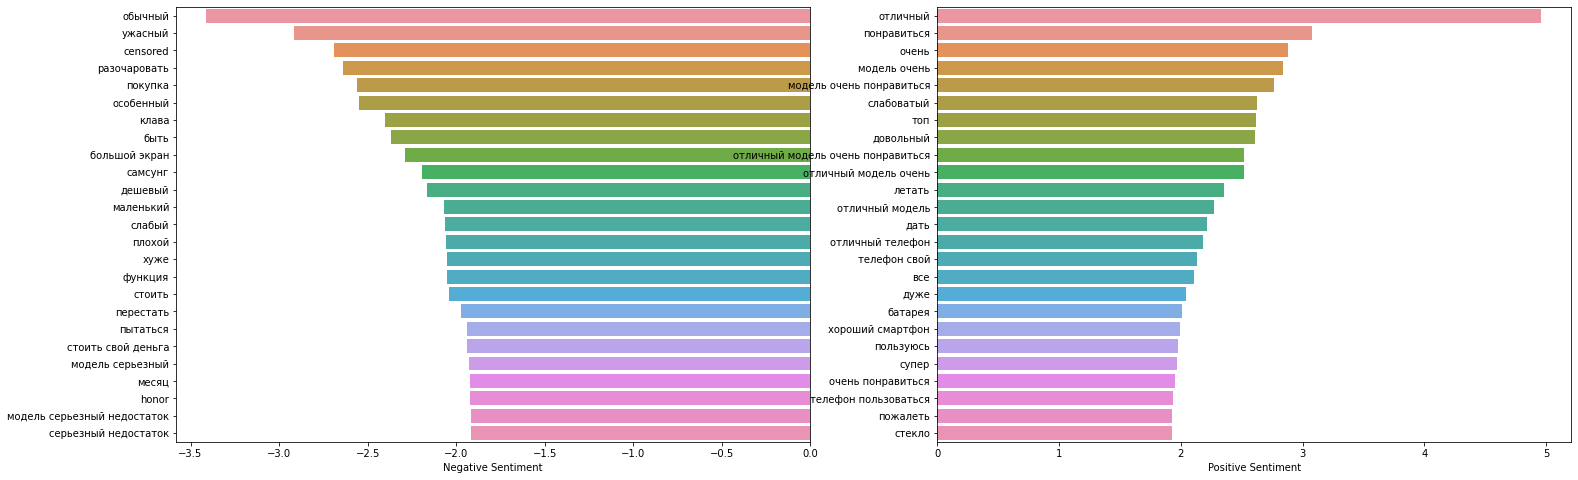

In [96]:
plot_feature_impotance(lr_no_reg.coef_[0])

In [97]:
lr_l2_reg = LogisticRegression(random_state=42, penalty='l2')
lr_l2_reg.fit(X_train_tf, y_train)
preds = lr_l2_reg.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))
print(f'ROC AUC score: {roc_auc_score(y_test, preds)}')

              precision    recall  f1-score   support

           0     0.8297    0.8118    0.8207       186
           1     0.8066    0.8249    0.8156       177

    accuracy                         0.8182       363
   macro avg     0.8182    0.8183    0.8181       363
weighted avg     0.8184    0.8182    0.8182       363

ROC AUC score: 0.818343357025697


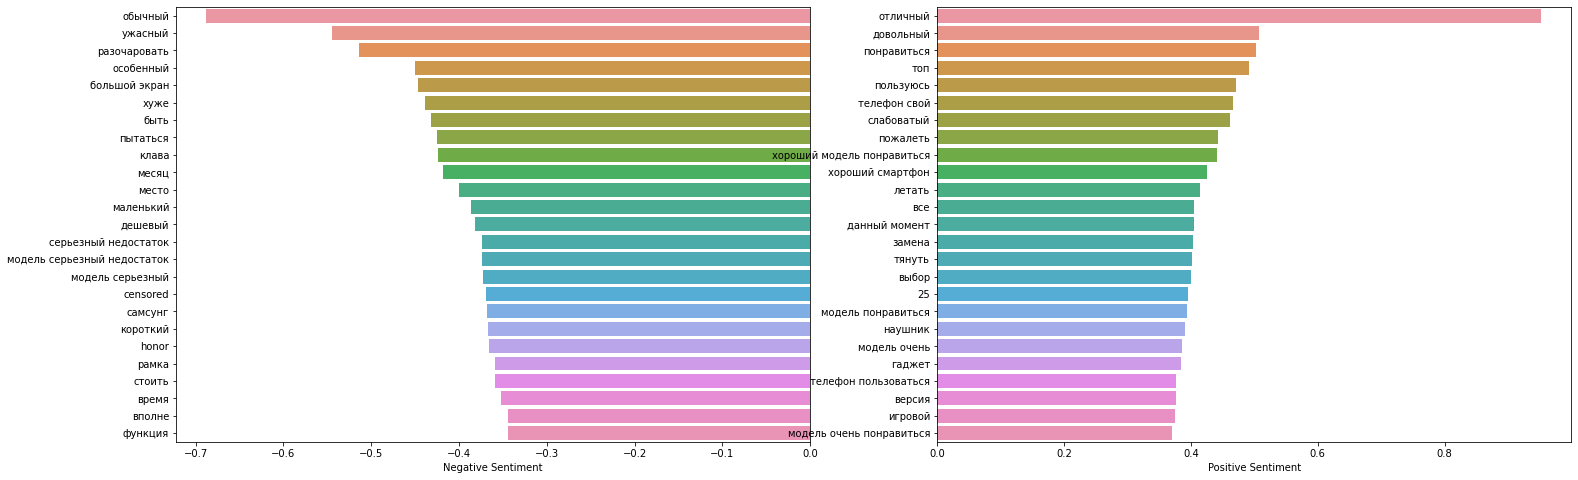

In [98]:
plot_feature_impotance(lr_l2_reg.coef_[0])

In [99]:
lr_l1_reg = LogisticRegression(random_state=42, penalty='l1', solver='liblinear')
lr_l1_reg.fit(X_train_tf, y_train)
preds = lr_l1_reg.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))
print(f'ROC AUC score: {roc_auc_score(y_test, preds)}')

              precision    recall  f1-score   support

           0     0.8042    0.8172    0.8107       186
           1     0.8046    0.7910    0.7977       177

    accuracy                         0.8044       363
   macro avg     0.8044    0.8041    0.8042       363
weighted avg     0.8044    0.8044    0.8044       363

ROC AUC score: 0.804082376526335


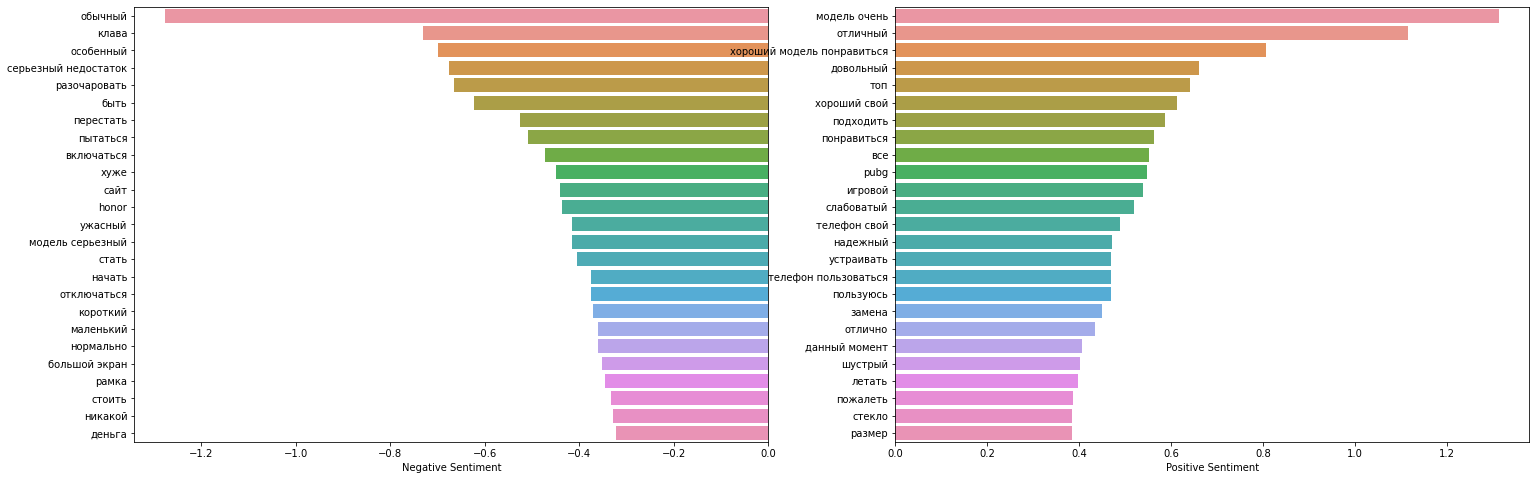

In [100]:
plot_feature_impotance(lr_l1_reg.coef_[0])